In [1]:
import numpy as np
import pandas as pd 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import zscore
from pingouin import wilcoxon as pgWilc
from sklearn import decomposition
from IPython.display import display, Latex
from sklearn.cluster import KMeans
import pickle
import sklearn.cluster as cluster
from pathlib import Path
import os
import glob
from tqdm import tqdm_notebook
from lifelines.plotting import plot_lifetimes
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.statistics import multivariate_logrank_test
from lifelines.statistics import pairwise_logrank_test

ModuleNotFoundError: No module named 'pingouin'

In [2]:
def zScoreEach(data):
    for col in data.columns:
        data[col] = zscore(data[col]).astype(float)
    return data

In [3]:
data1=pd.read_csv('miceage.csv') #Loading accompanying Mice data file

# SUMMARY TABLE (Patch/Average Resolution)

                                                   Save Rawdata

In [15]:
folder = '/Users/jacob/Desktop/Python project files'
# folder = r'\\metlab25\G\Pathology\QuPath\Sereen\Sacoma\Features\results' #Folder Location of your summary table
data_file = pd.read_csv(os.path.join(folder, 'p53SumTable.csv')) #Summary table file name

rawdata = data_file.iloc[:,1:]
rawdata.to_pickle(os.path.join(folder, 'rawdata.pickle'))
rawdata = pd.read_pickle(os.path.join(folder, 'rawdata.pickle'))
rawdata.to_csv('Test1.csv')

                                               Save Specific Labels

In [16]:
labels = data_file = data_file.iloc[:,:1]

                                       Create and Save Labels (32 Characters)

In [17]:
mousedata = {'Mouse':data_file['Image'].str[2:6]} #Gets the mouse characters from the 32 character code in a seperate vector 
linedata = {'Line':data_file['Image'].str[21:25]}
slicedata = {'Series':data_file['Image'].str[38:47]}
posdata = {'Patch Position (X_Y)':data_file['Image'].str[48:]}
codedata = {'CodeSeries':data_file['Image'].str[:47]}
Mouse = pd.DataFrame(mousedata)
Lines = pd.DataFrame(linedata)
Slice = pd.DataFrame(slicedata)
Position = pd.DataFrame(posdata)
Code = pd.DataFrame(codedata)
Position['Patch Position (X_Y)'] = Position['Patch Position (X_Y)'].str.replace('.png.png.txt', '')
labels = pd.concat([Mouse,Lines,Slice,Code,data_file['Image']],axis = 1)

/Users/jacob/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()


In [18]:
#Parsing the ROI positions into the labels dataframe

X_ROI = []
Y_ROI = []

for i in Position['Patch Position (X_Y)']:
    d= i.split('_',1)
    xroi = int(d[0])
    yroi = int(d[1])
    X_ROI.append(xroi)
    Y_ROI.append(yroi)

labels = labels.reset_index()
#sumTable = sumTable.reset_index()
labels = pd.concat([labels,pd.DataFrame(X_ROI, columns=["X_ROI"]), pd.DataFrame(Y_ROI, columns=["Y_ROI"])],axis = 1)
# inem = inem.reset_index()
# inem2 = pd.concat([labels,inem],axis = 1)
del labels['index']

In [19]:
#linelabels = linelabels.sort_values(by = label , ascending=False) #Sorting the data by Line (top to bottom)

labels.to_pickle(os.path.join(folder, 'rawlabel.pickle'))
rawlabels = pd.read_pickle(os.path.join(folder, 'rawlabel.pickle'))

In [20]:
rawdata
rawdata.to_csv('test.csv')

In [21]:
rawlabels

,Mouse,Line,Series,CodeSeries,Image,X_ROI,Y_ROI
0,0002,0000,Series 1,NC0002000000F600HH0000000P010600.SCN - Series 1,NC0002000000F600HH0000000P010600.SCN - Series ...,10,28
1,0002,0000,Series 1,NC0002000000F600HH0000000P010600.SCN - Series 1,NC0002000000F600HH0000000P010600.SCN - Series ...,12,15
2,0002,0000,Series 1,NC0002000000F600HH0000000P010600.SCN - Series 1,NC0002000000F600HH0000000P010600.SCN - Series ...,13,23
3,0002,0000,Series 1,NC0002000000F600HH0000000P010600.SCN - Series 1,NC0002000000F600HH0000000P010600.SCN - Series ...,14,30
4,0002,0000,Series 1,NC0002000000F600HH0000000P010600.SCN - Series 1,NC0002000000F600HH0000000P010600.SCN - Series ...,16,17
...,...,...,...,...,...,...,...
838,5154,0000,Series 1,NC515400000060000H0000000P030600.SCN - Series 1,NC515400000060000H0000000P030600.SCN - Series ...,5,13
839,5154,0000,Series 1,NC515400000060000H0000000P030600.SCN - Series 1,NC515400000060000H0000000P030600.SCN - Series ...,7,15
840,5154,0000,Series 1,NC515400000060000H0000000P030600.SCN - Series 1,NC515400000060000H0000000P030600.SCN - Series ...,7,16
841,5154,0000,Series 1,NC515400000060000H0000000P030600.SCN - Series 1,NC515400000060000H0000000P030600.SCN - Series ...,7,17


# -----------------------------------------------------------------------------------------------------------

# BORUTA FEATURE SELECTION

In [22]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import os
import numpy as np
import pickle

                                Define label by which boruto features will classify by

In [23]:
label = 'Mouse' #define desired label here

if label == 'Line':
    rawdf = pd.concat([rawlabels['Line'],rawdata],axis=1)
    rawdf = rawdf[rawdf.Line != '0000']
    rawlabels = rawlabels[rawlabels.Line != '0000']
    rawdf.drop('Line',axis=1, inplace=True)
    rawdata = rawdf.copy()
    rawdata.to_pickle(os.path.join(folder, 'rawdata_line.pickle')) 
    rawlabels.to_pickle(os.path.join(folder, 'rawlabel_line.pickle'))
#     rd = pd.read_pickle(os.path.join(folder, 'rawdata_line.pickle'))
#     rl = pd.read_pickle(os.path.join(folder, 'rawdata_line.pickle'))

In [33]:
#folder = r'\\metlab25\G\AymanData\QuPath\NewPipeline\features' #Path of your pickle files
#folder = r'\\metlab25\G\AymanData\QuPath\NewPipeline\features\results' 
# data_file = pd.read_csv(os.path.join(folder, 'QuPathNormalisationFinal.csv')) #Summary table file name

if label == 'Line':
    rawdata = pd.read_pickle(os.path.join(folder,'rawdata_line.pickle')) #Change to rawdata_line if running Line
    rawlabel = pd.read_pickle(os.path.join(folder,'rawlabel_line.pickle')) 
else:    
    rawdata = pd.read_pickle(os.path.join(folder,'rawdata.pickle'))  
    rawlabel = pd.read_pickle(os.path.join(folder,'rawlabel.pickle'))
# rawdata = pd.read_pickle(os.path.join(folder,'rawdata_line.pickle')) #Change to rawdata_line if running Line
rawdatacopy = rawdata.copy()
zscore_rawdata = zScoreEach(rawdatacopy)
rawlabel = pd.read_pickle(os.path.join(folder,'rawlabel.pickle'))
# rawlabel = pd.read_pickle(os.path.join(folder,'rawlabel_line.pickle')) #Change to rawlabels_line if running Line

my_list = zscore_rawdata.columns.values.tolist() 
X = zscore_rawdata[my_list].values
X = pd.DataFrame(X).fillna(value=0).values
y = rawlabel[label].values.ravel() 



                                    Defining Forest Classifier, Training Model

In [34]:
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X, y)

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	495
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	495
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	495
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	495
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	495
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	495
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	495
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	399
Tentative: 	96
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	399
Tentative: 	96
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	399
Tentative: 	96
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	399
Tentative: 	96
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	418
Tentative: 	77
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	418
Tentative: 	75
Rejected: 	2
Iteration: 	14 / 100
Confirmed: 	418
Tentative: 	75
Rejected: 	2
Iteration: 	15 / 100
Confirmed: 	418
Tentative: 	75
Rejected: 	2
Iteration: 	16 / 100
Confirmed: 	425
Tent

array([15, 16,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  8,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  3,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  8,  1,  1,  1,
        1,  1,  1,  2,  1,  1,  1,  2,  1,  8, 13,  1,  1,  1,  2,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

                                 Create Reduced/Concentrated Table & Save to Pickle

In [37]:
final_features = list()
indexes = np.where(feat_selector.support_ == True)
for x in np.nditer(indexes):
    final_features.append(my_list[x])

eminem = rawdata[final_features]
eminemlabels = rawlabel.copy()


# Write and read reduced summary table to pickle variables

#folder = r'\\metlab25\G\AymanData\QuPath\NewPipeline\features'
with open(os.path.join(folder, 'eminem.pickle'), "wb") as f:
    pickle.dump((eminem,eminemlabels), f)
    
with open(os.path.join(folder, 'eminem.pickle'), "rb") as f:
    em,inem = pickle.load(f) 

# --------------------------------------------------------------------------------------------------------

# PCA & K-MEANS CLUSTERING

In [38]:
from utils import *

In [40]:
#folder = r'\\metlab25\G\AymanData\QuPath\NewPipeline\features'
with open(os.path.join(folder, 'eminem.pickle'), "rb") as f: #Include the '_line' if you are running Line/QTL analysis!
    rawdata,rawlabels = pickle.load(f) 

features = rawdata.columns.values.tolist()

                                         Standard PCA & Variance Explained

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

There are 2 signficant components


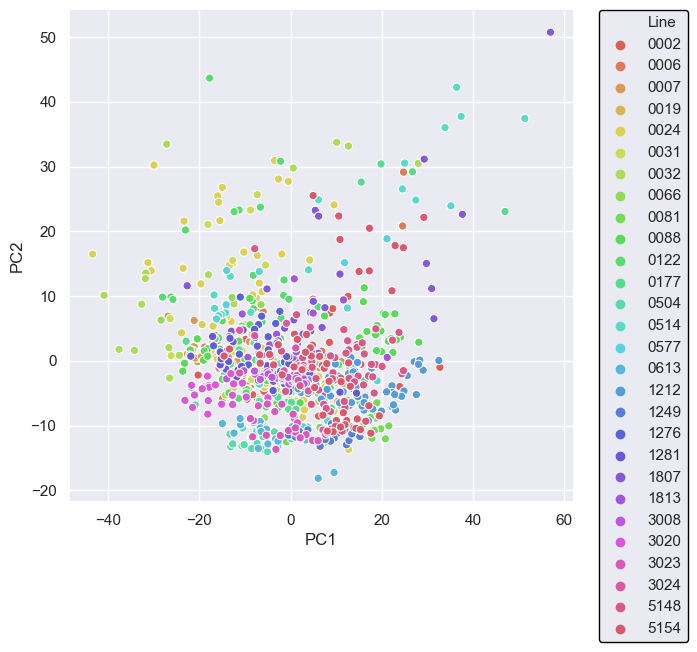

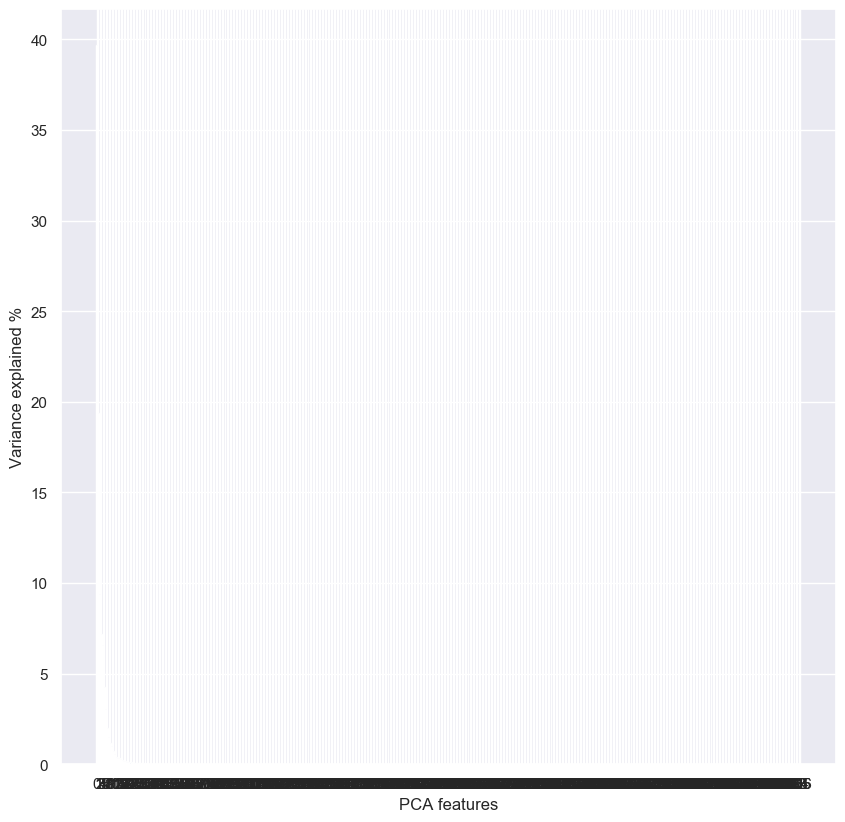

In [41]:
Groups = 'Mouse'
pca_df,pca,pca_transformed = pcaCalcOneExp(zScoreEach(rawdata),rawlabels[Groups],'PCA',-1,nColor=0,nShades=0)

In [48]:
# K- optimization
K=range(1,12)
wss = []
for k in K:
    kmeans=cluster.KMeans(n_clusters=k,init="k-means++")
    kmeans=kmeans.fit(rawdata)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)

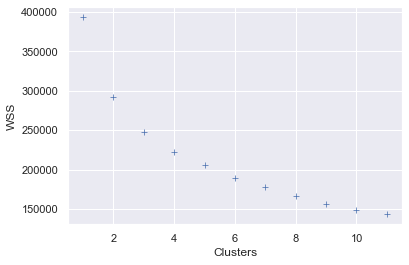

In [49]:
#Elbow diagram
mycenters = pd.DataFrame({'Clusters' : K, 'WSS' : wss})
sns.scatterplot(x = 'Clusters', y = 'WSS', data = mycenters, marker="+")

In [50]:
#Silhouette extraction optimizing number of clusters
max=0
clusters=0
for i in range(3,13):
    labels=cluster.KMeans(n_clusters=i,init="k-means++",random_state=200).fit(rawdata).labels_
    if max < metrics.silhouette_score(rawdata,labels,metric="euclidean",sample_size=1000,random_state=200):
            max= metrics.silhouette_score(rawdata,labels,metric="euclidean",sample_size=1000,random_state=200)
            num_of_clusters=i

                                                  KMEANS PCA

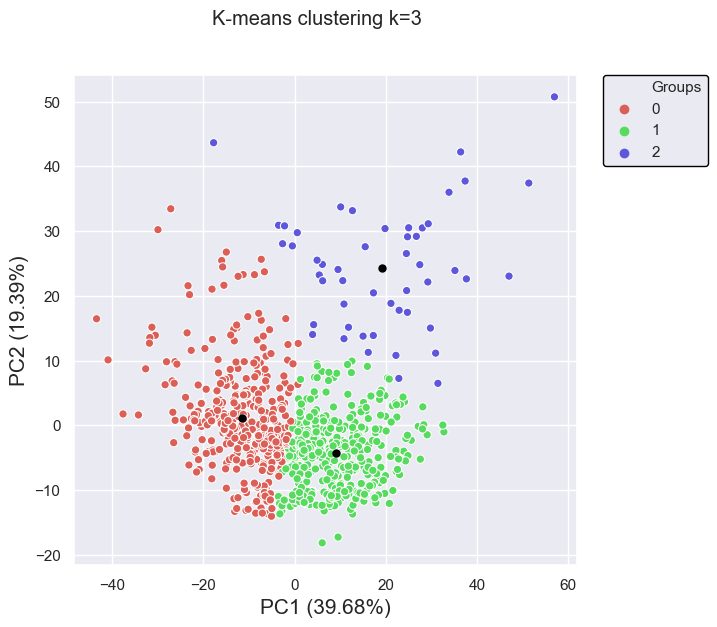

In [51]:
kmeans_pca,xlim_kmeans,ylim_kmeans = kmeansPlot(num_of_clusters,pca_transformed,pca,rawlabels[Groups]) 

# ---------------------------------------------------------------------------------------------------------

# CONFUSION MATRIX

In [52]:
array = rawlabels[Groups]
labels = list(array)
kgroups = kmeans_pca['Groups']
pred = list(kgroups)

In [53]:
from collections import Counter
a = dict(Counter(array))
a

{'0002': 36,
 '0006': 20,
 '0007': 32,
 '0019': 21,
 '0024': 102,
 '0031': 17,
 '0032': 23,
 '0066': 14,
 '0081': 26,
 '0088': 52,
 '0122': 30,
 '0177': 25,
 '0504': 20,
 '0514': 20,
 '0577': 27,
 '0613': 23,
 '1807': 28,
 '1813': 17,
 '1212': 53,
 '1249': 23,
 '1276': 20,
 '1281': 29,
 '3008': 27,
 '3020': 20,
 '3023': 22,
 '3024': 11,
 '5148': 47,
 '5154': 58}

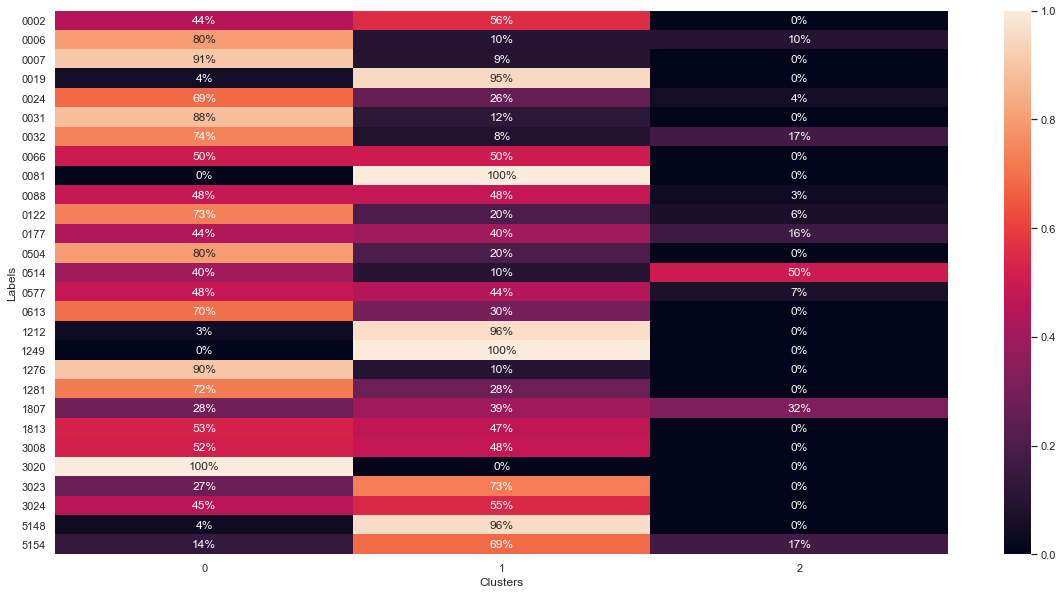

In [54]:

# Create a DataFrame with labels and varieties as columns: df
df = pd.DataFrame({'Labels': labels, 'Clusters': pred})

# Create crosstab: ct
ct = pd.crosstab(df['Labels'], df['Clusters'],normalize = 'index')

# Display ct
fig, ax = plt.subplots(figsize=(20,10))         
sns.heatmap(ct, annot=True)
ax.set_ylim([len(np.unique(array)),0])
for t in ax.texts: t.set_text(math.floor(float(t.get_text())*100))
for t in ax.texts: t.set_text((t.get_text()) + "%")
plt.show()

In [55]:
KM_filename = 'ByGroups_QTL3.csv'
with open(os.path.join(folder, KM_filename),'w') as outfile:
    ct.to_csv(outfile, header=True)

# Kaplan Meier input 

In [56]:
data2=pd.read_csv('ByGroups_QTL3.csv')
data2['Age']=0
data2['L/D']=1

In [57]:
#Matching external mice data to ct 
for i in range(len(data2)):
    for j in range(len(data1)):
        if data2['Labels'][i]==data1['Mouse'][j]:
            data2['Age'][i]=data1['Age'][j]
            data2['L/D'][i]=data1['L/D'][j]
            j+=1
    i+=1


/Users/jacob/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/jacob/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [61]:
data2.to_csv('Test_data.csv')
data3=data2.drop(["Labels","Age","L/D"],axis=1)
data3
data3['Max']=data3.max(axis=1)

In [62]:
#Normalizing all values
for i in range (num_of_clusters): 
    for j in range(len(data2)):
        if data2[str(i)][j]>=data3['Max'][j]:  #Threshold needs to be optimized
            data2[str(i)][j]=1
        else:
            data2[str(i)][j]=0
        j+=1
    i+=1

/Users/jacob/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/jacob/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [63]:
#eliminating rows that dont match up with external mice file
data2=data2[data2['Age']>0]
data2=data2.reset_index()
data2

,level_0,index,Labels,0,1,2,Age,L/D
0,0,0,2,0.0,1.0,0.0,361,1
1,1,1,6,1.0,0.0,0.0,481,1
2,2,2,7,0.0,0.0,0.0,481,1
3,3,3,19,0.0,0.0,0.0,506,1
4,4,4,24,0.0,0.0,0.0,401,1
5,5,5,31,0.0,0.0,0.0,244,1
6,6,6,32,0.0,0.0,0.0,244,1
7,7,7,66,0.0,0.0,0.0,286,1
8,8,8,81,0.0,0.0,0.0,281,1
9,9,9,88,0.0,0.0,0.0,129,1


In [72]:
#Re-naming group headings and creating new column called groups
to_groups(data2)

/Users/jacob/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jacob/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,level_0,index,Labels,Group A,Group B,Group C,Age,L/D,Groups
0,0,0,2,0.0,1.0,0.0,361,1,B
1,1,1,6,1.0,0.0,0.0,481,1,A
2,2,2,7,0.0,0.0,0.0,481,1,0
3,3,3,19,0.0,0.0,0.0,506,1,0
4,4,4,24,0.0,0.0,0.0,401,1,0
5,5,5,31,0.0,0.0,0.0,244,1,0
6,6,6,32,0.0,0.0,0.0,244,1,0
7,7,7,66,0.0,0.0,0.0,286,1,0
8,8,8,81,0.0,0.0,0.0,281,1,0
9,9,9,88,0.0,0.0,0.0,129,1,0


# Kaplan Meier curve

Text(0.5, 0, 'Months')

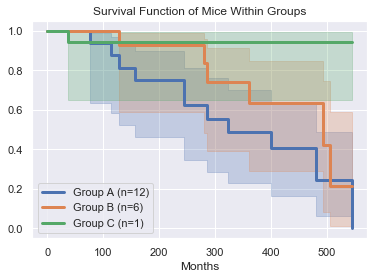

In [58]:
data=pd.read_csv('KM_input.csv');
kmf = KaplanMeierFitter() 
T=data['Age']
data=data.drop("index",axis=1)
headings=data.columns.tolist()
for i in range(len(headings)-5):
    kmf.fit(T,data[headings[i+2]],label=headings[i+2]+' (n=%d)'%data[headings[i+2]].tolist().count(1))
    kmf.plot(linewidth=3.0)
    i+=1
plt.title('Survival Function of Mice Within Groups');
plt.xlabel('Months')

# Log rank test

In [59]:
#results = multivariate_logrank_test(data['Age'],data['Groups'], data['L/D'])
#results.print_summary()
#results = pairwise_logrank_test(data['Age'], data['Groups'], data['L/D'])
#results.print_summary()
results = multivariate_logrank_test(data['Age'], data['Groups'], data['L/D'],weightings = 'wilcoxon')
results.print_summary()

<lifelines.StatisticalResult: multivariate_Wilcoxon_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_Wilcoxon_test

---
 test_statistic      p  -log2(p)
          16.34 <0.005     11.79

# COX analysis

In [66]:
data_cox=data2
data_cox

,level_0,index,Labels,Group A,Group B,Group C,Age,L/D,Groups
0,0,0,2,0.0,1.0,0.0,361,1,0
1,1,1,6,1.0,0.0,0.0,481,1,0
2,2,2,7,0.0,0.0,0.0,481,1,0
3,3,3,19,0.0,0.0,0.0,506,1,0
4,4,4,24,0.0,0.0,0.0,401,1,0
5,5,5,31,0.0,0.0,0.0,244,1,0
6,6,6,32,0.0,0.0,0.0,244,1,0
7,7,7,66,0.0,0.0,0.0,286,1,0
8,8,8,81,0.0,0.0,0.0,281,1,0
9,9,9,88,0.0,0.0,0.0,129,1,0


In [67]:
for i in range(len(data_cox)):
    if data_cox['Groups'][i]== 'A':
        data_cox['Groups'][i]= 1
    if data_cox['Groups'][i]== 'B':
        data_cox['Groups'][i]= 2
    if data_cox['Groups'][i]== 'C':
        data_cox['Groups'][i]= 3
    if data_cox['Groups'][i]== 'Ignore':
        data_cox['Groups'][i]= 0
    #if data_cox['Groups'][i]== 'D':
        #data_cox['Groups'][i]= 4
    #if data_cox['Groups'][i]== 'E':
        #data_cox['Groups'][i]= 5
    #if data_cox['Groups'][i]== 'F':
        #data_cox['Groups'][i]= 6
   # One may add these in dependednt on the optimal ammount of clusters

In [68]:
data_cox=data_cox[["Age","L/D","Groups"]]
data_cox

,Age,L/D,Groups
0,361,1,0
1,481,1,0
2,481,1,0
3,506,1,0
4,401,1,0
5,244,1,0
6,244,1,0
7,286,1,0
8,281,1,0
9,129,1,0


In [69]:
cph=CoxPHFitter(penalizer=0.1)
cph.fit(data_cox,'Age',event_col='L/D',show_progress=True)
cph.print_summary()

/Users/jacob/opt/anaconda3/lib/python3.7/site-packages/lifelines/utils/__init__.py:1090: ConvergenceWarning: Column(s) ['Groups'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/jacob/opt/anaconda3/lib/python3.7/site-packages/lifelines/utils/__init__.py:788: RuntimeWarning: invalid value encountered in true_divide
  return (X - mean) / std


ConvergenceError: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model

# COLOR GROUPS

In [70]:
dftable = pd.concat([pca_df,kmeans_pca['Groups']],axis =1)

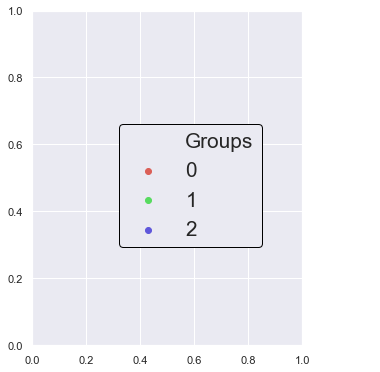

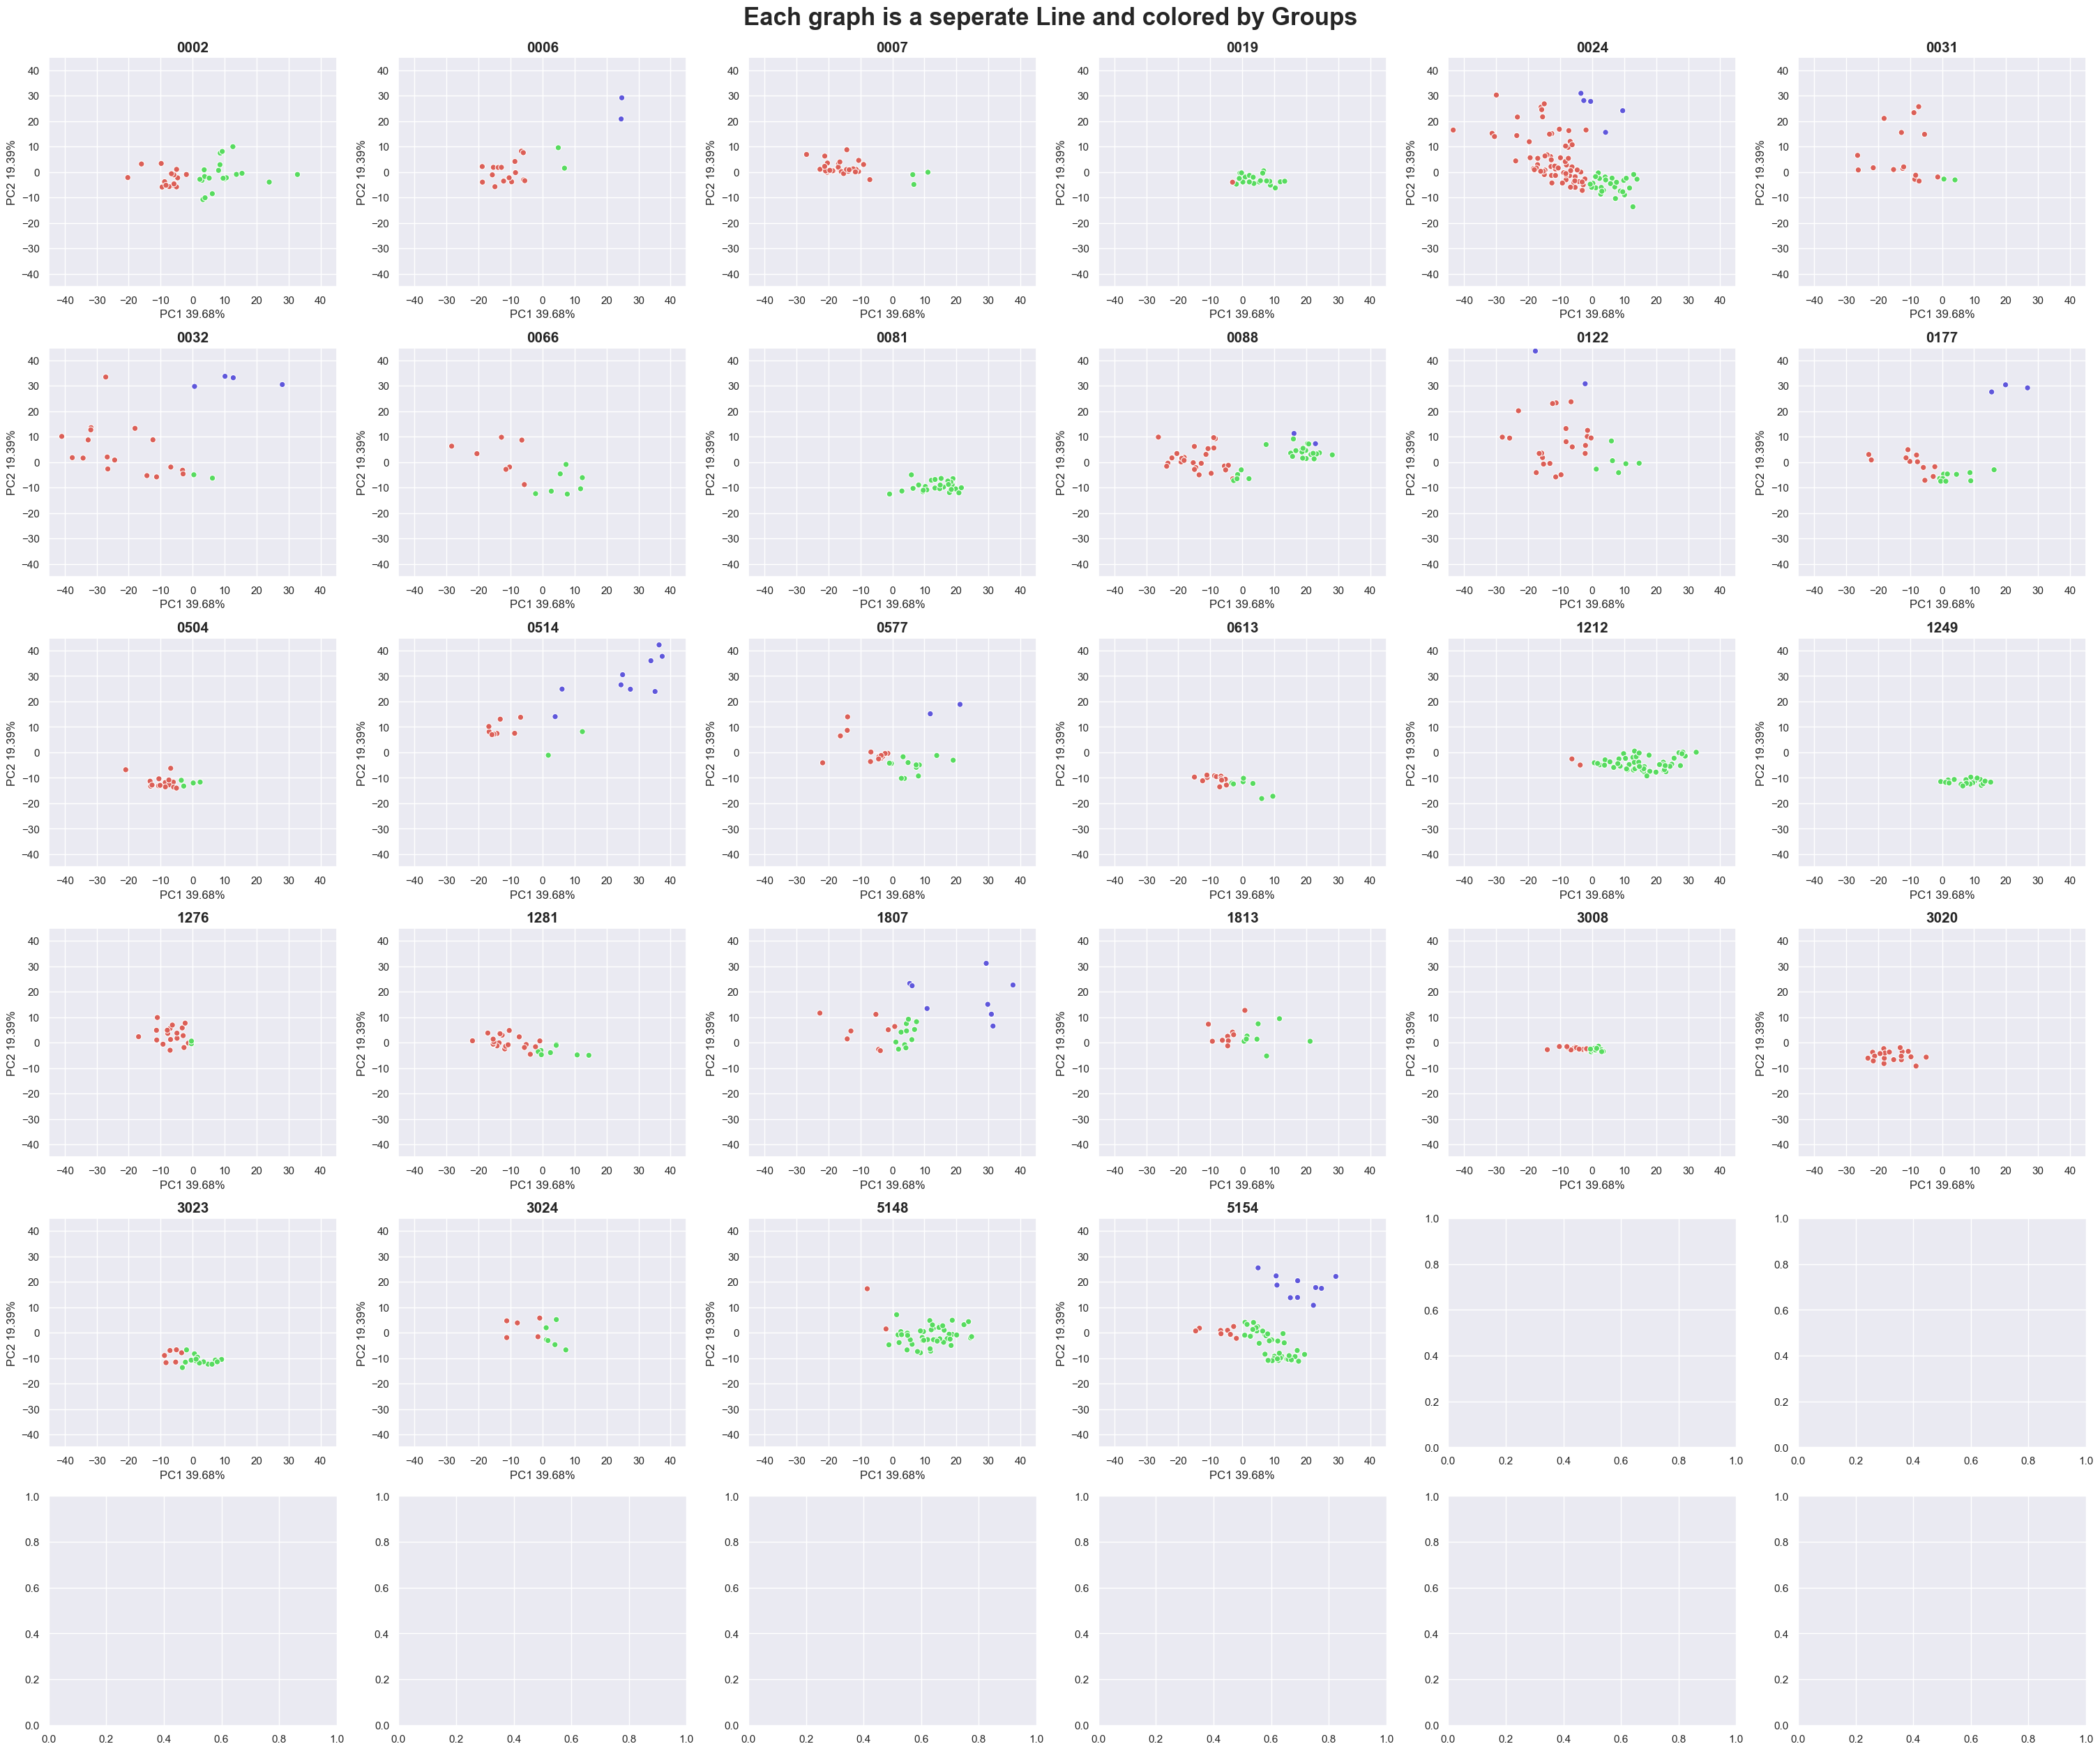

In [71]:
Par1 = 'Groups'
Par2 = 'Line' #Change to Line of Mouse for the correct title
PCA_colorPar1_titlePar2(pca, dftable, Par1, Par2, figsize = (30,25), labelsPar1='', labelsPar2='',
                            nrows=0, nColor=0, nShades=0, nColorTreat=0,nShadesTreat=0,
                            nColorLay=0, nShadesLay=0,xlim_kmeans=[-45,45],ylim_kmeans=[-45,45])

# -----------------------------------------------------------------------------------------------------------

# FEATURE DISTRIBUTION GROUPS

In [66]:
rawdata.reset_index(drop=True, inplace=True)
rawlabels.reset_index(drop=True, inplace=True)
kmeans_pca['Groups'].reset_index(drop=True, inplace=True)
raw2 = pd.concat([rawdata,rawlabels,kmeans_pca['Groups']],axis =1)

<IPython.core.display.Latex object>

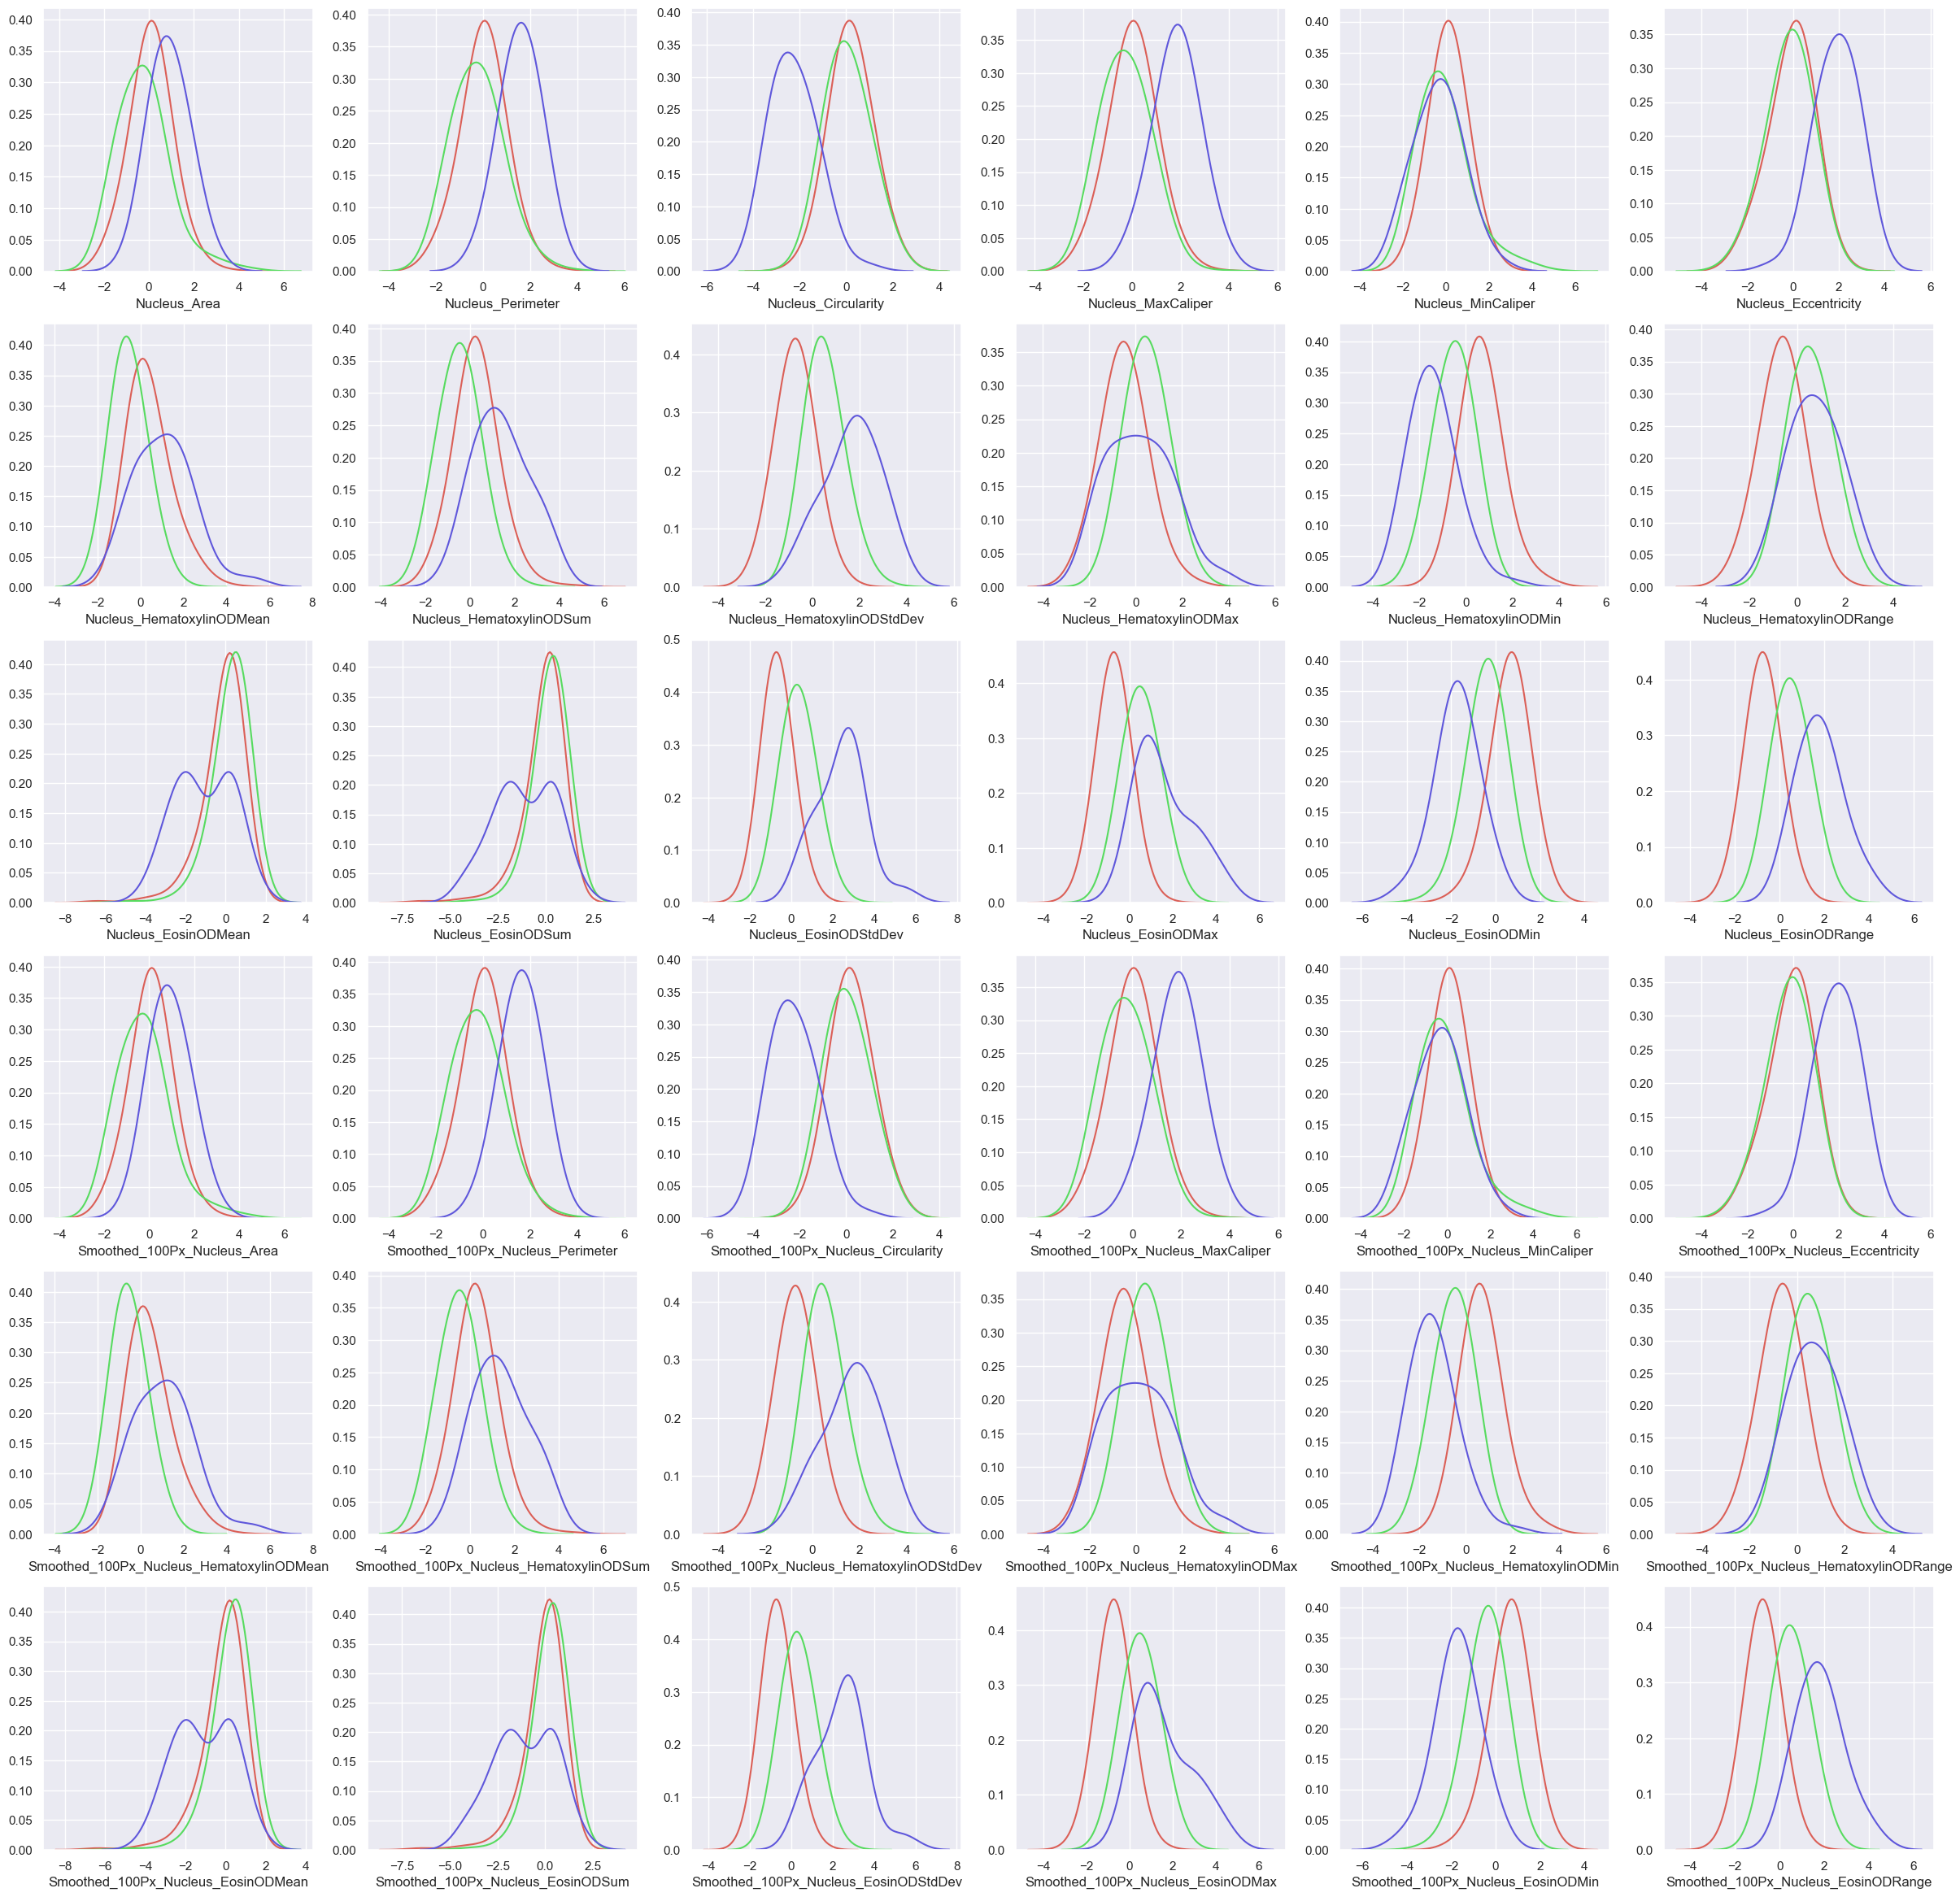

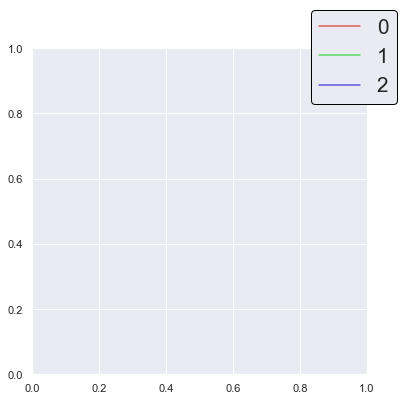

In [67]:
Groups = 'Groups'

histogramDataKDELabels(range(num_of_clusters),raw2,features,0,Par=Groups,nColor=0, nShades=0)

# FEATURE DISTRIBUTION LABELS

<IPython.core.display.Latex object>

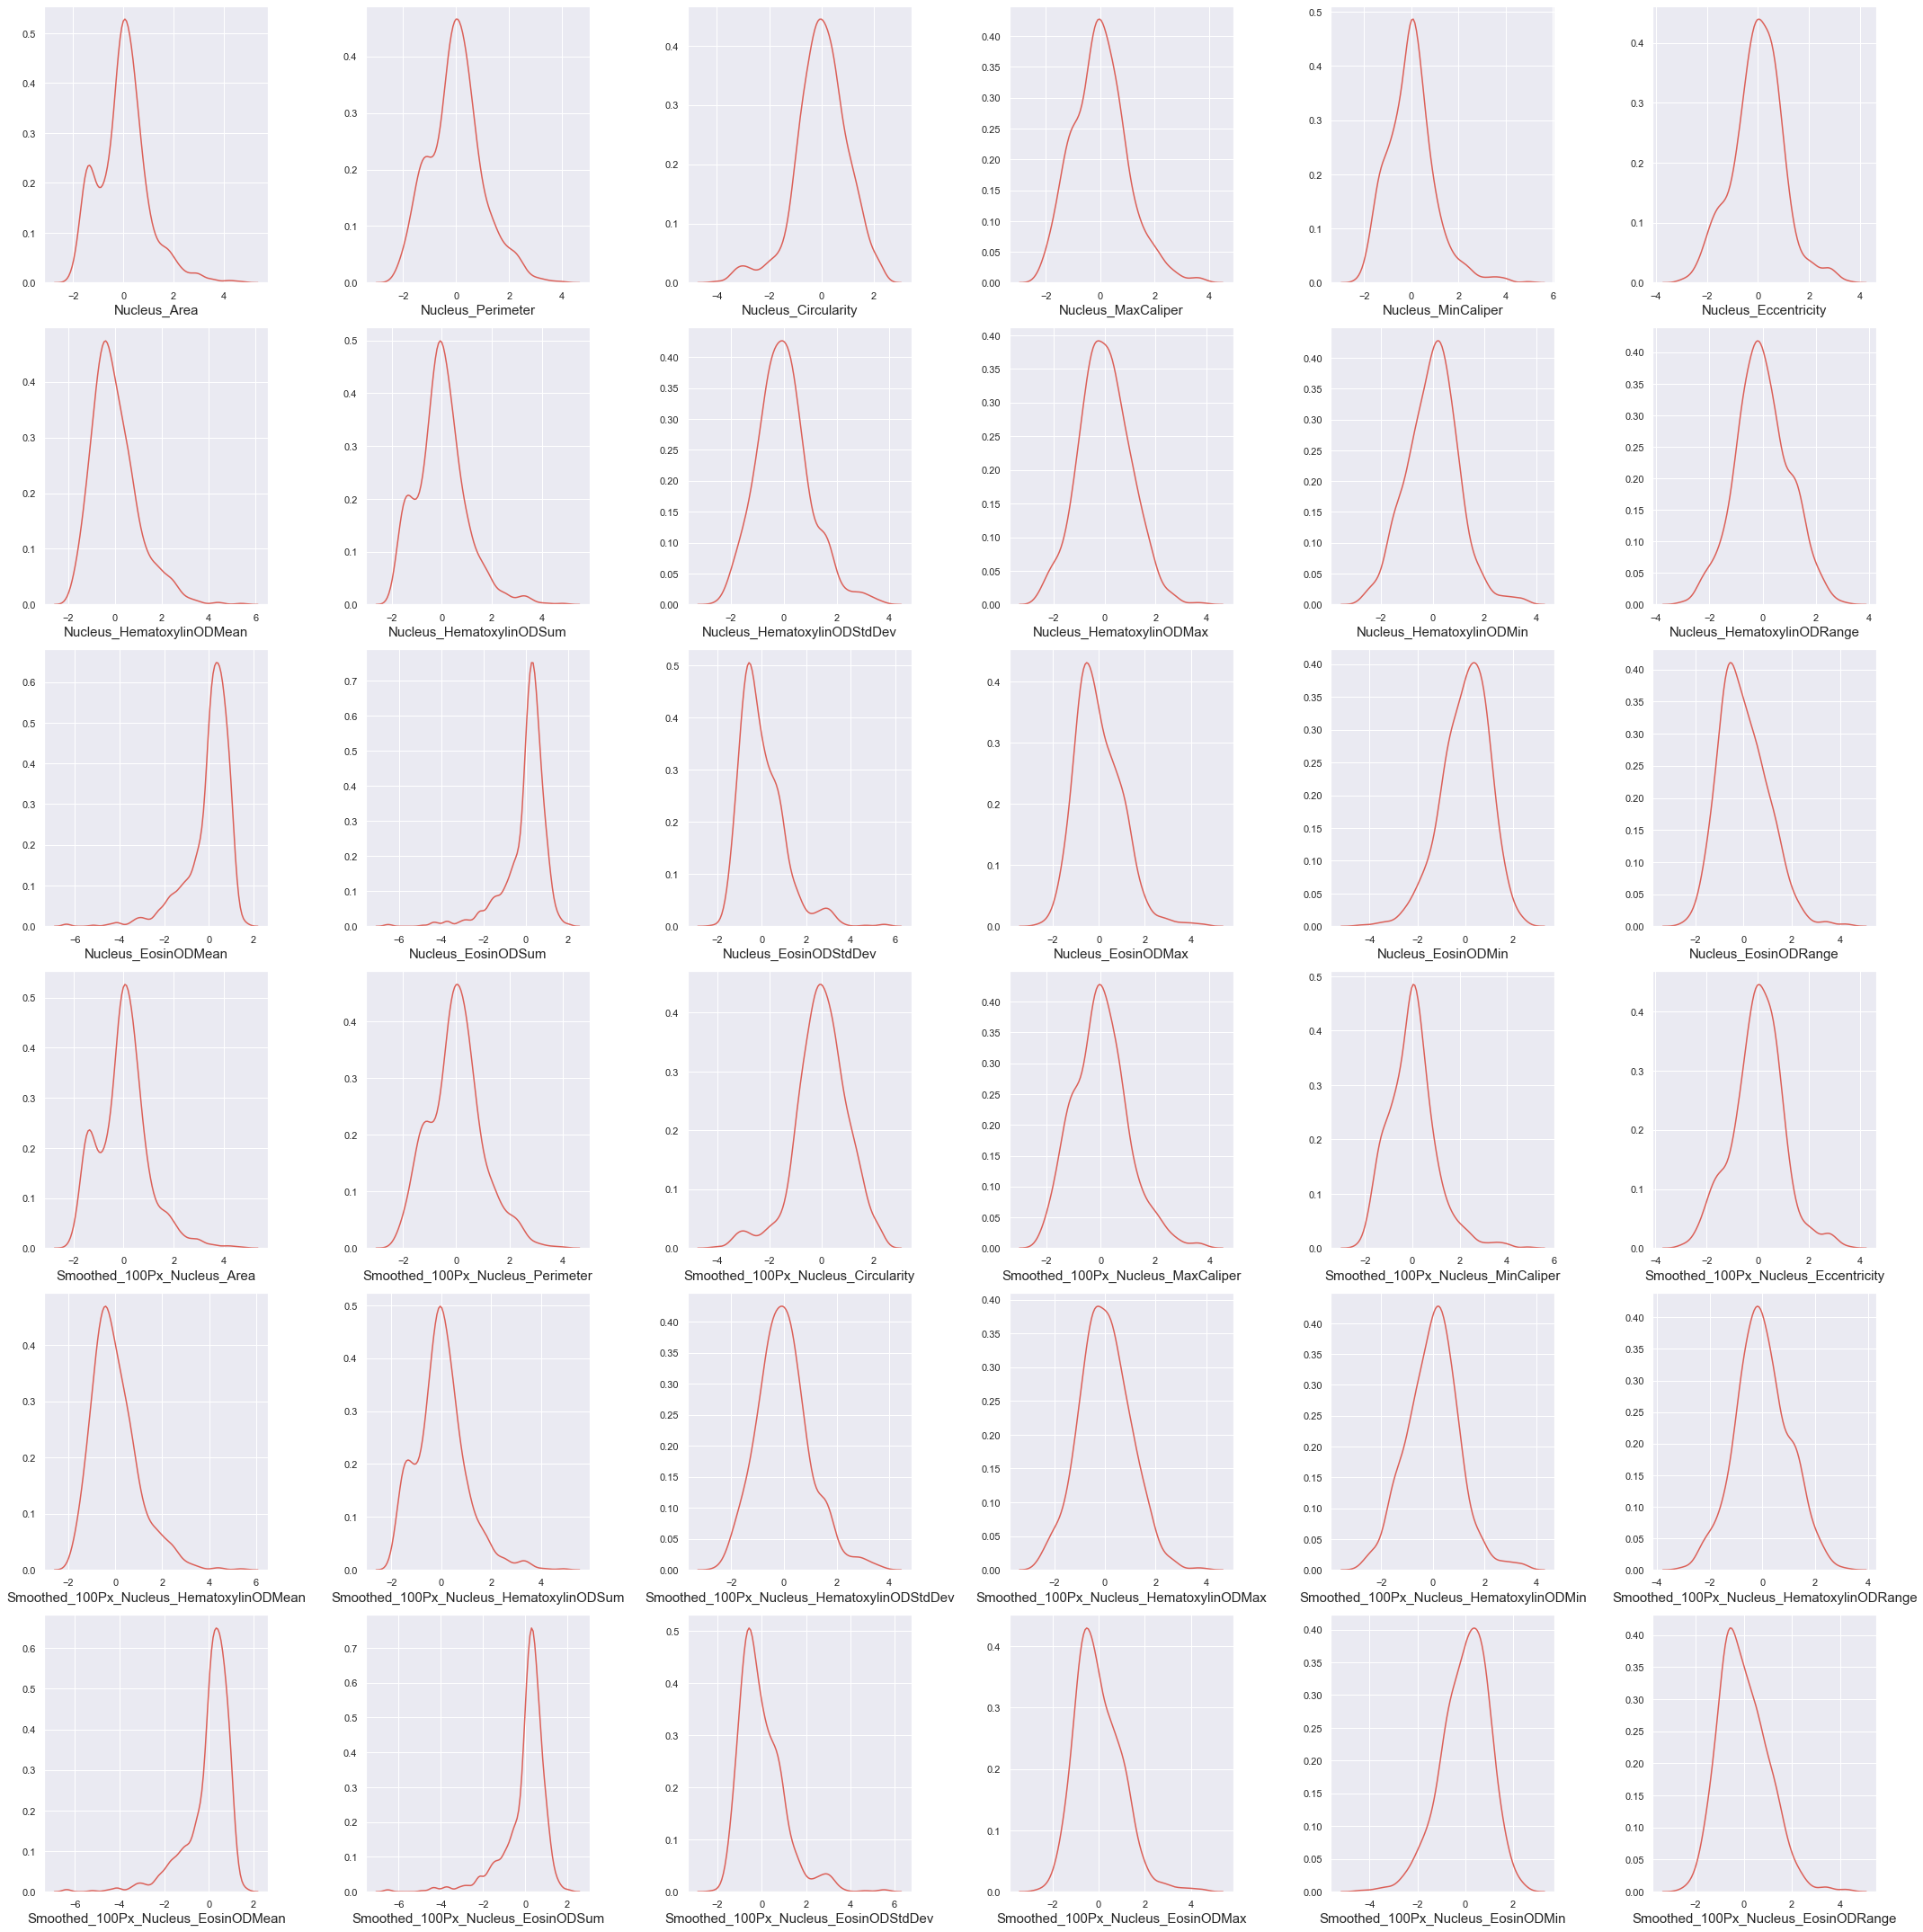

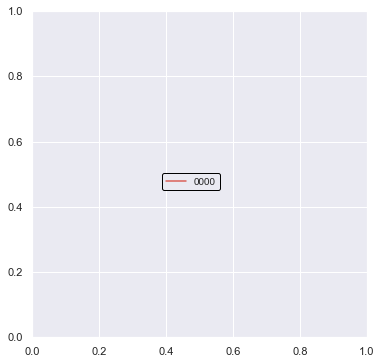

In [68]:
Groups = 'Line' #change to correct label
ad = np.unique(raw2[Groups])
histogramDataKDE(ad,raw2,features,1,nColor=0, nShades=0)

                                             Search Specific Features

In [69]:
#Put the names of your features in the array, this will show you the index of where these features are located top = ["ROI_1_00PxPerPixel_Residual_Mean", "ClusterMean_ROI_1_00PxPerPixel_Residual_Mean"]
top = ["Nucleus_HematoxylinODSum", "Smoothed_100Px_Nucleus_HematoxylinODSum", 
       "Smoothed_50Px_Nucleus_HematoxylinODSum","Smoothed_20Px_Nucleus_HematoxylinODSum",
      "ClusterMean_Nucleus_HematoxylinODSum","ClusterMean_Smoothed_100Px_Nucleus_HematoxylinODSum",
      "ClusterMean_Smoothed_50Px_Nucleus_HematoxylinODSum","ClusterMean_Smoothed_20Px_Nucleus_HematoxylinODSum"]
N=np.where(np.isin(features,top))
N

(array([  7,  25,  44,  63, 241, 258, 277, 296]),)

<IPython.core.display.Latex object>

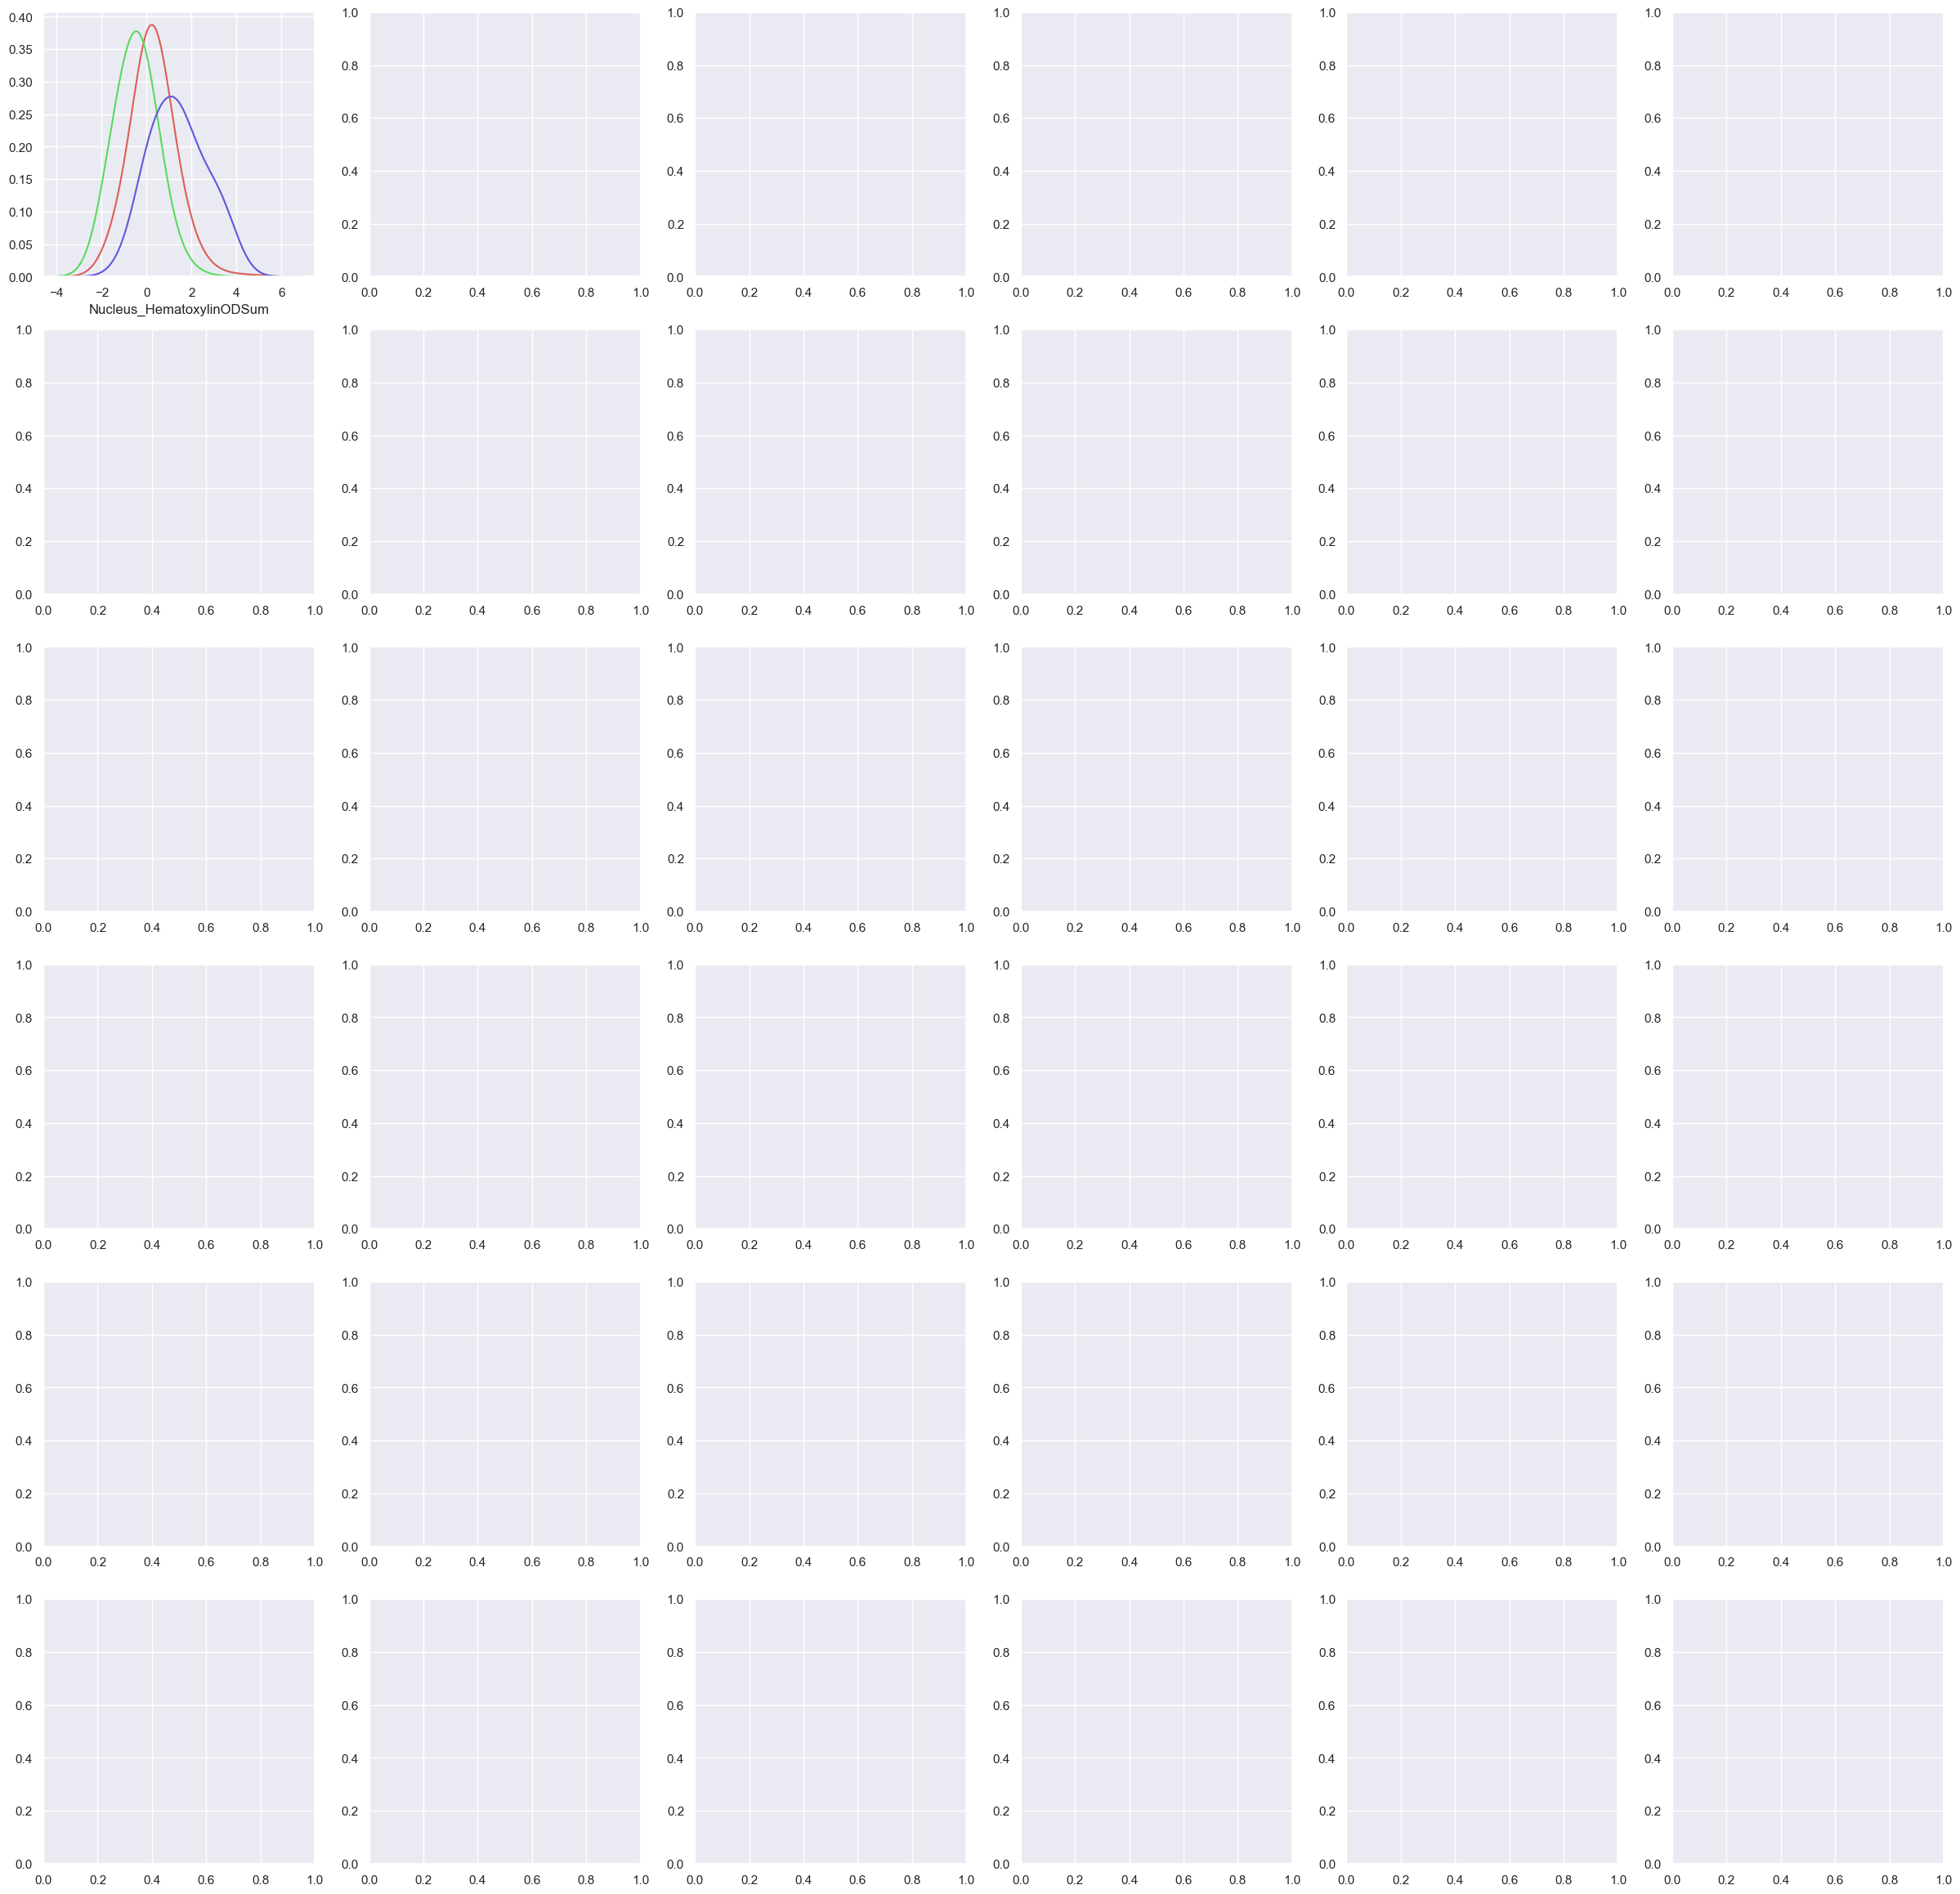

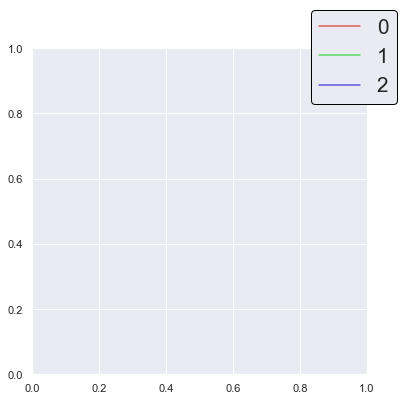

In [70]:
Groups = 'Groups'
idx = 0
histogramDataKDELabels(range(num_of_clusters),raw2,features[(N[0][idx]):(N[0][idx]+1)],0,Par=Groups,nColor=0, nShades=0)

# -----------------------------------------------------------------------------------------------------------

# Divide the Raw Data into Clusters

In [71]:
rawdata.reset_index(drop=True, inplace=True)
kmeans_pca.reset_index(drop=True, inplace=True)
raw = pd.concat([rawdata,kmeans_pca['Groups']],axis=1)

In [72]:
rawA = raw[raw.Groups == 0]
rawB = raw[raw.Groups == 1]
rawC = raw[raw.Groups == 2]
# rawD = raw[raw.Groups == 3]   #For 4 groups 

In [73]:
rawA

,Nucleus_Area,Nucleus_Perimeter,Nucleus_Circularity,Nucleus_MaxCaliper,Nucleus_MinCaliper,Nucleus_Eccentricity,Nucleus_HematoxylinODMean,Nucleus_HematoxylinODSum,Nucleus_HematoxylinODStdDev,Nucleus_HematoxylinODMax,...,ClusterMean_ROI_1_00PxPerPixel_Brightness_HaralickInformation_1,ClusterMean_Delaunay_NumNeighbors,ClusterMean_Delaunay_MeanDistance,ClusterMean_Delaunay_MedianDistance,ClusterMean_Delaunay_MaxDistance,ClusterMean_Delaunay_MinDistance,ClusterMean_Delaunay_MeanTriangleArea,ClusterMean_Delaunay_MaxTriangleArea,ClusterSize,Groups
4,1.598487,1.296633,-0.249198,0.994439,1.841207,0.115902,-0.535394,0.735635,-0.691672,-0.709496,...,0.052901,0.156439,-0.041071,0.034082,-0.180176,0.405687,-0.195592,-0.305483,0.063648,0
7,1.558530,1.218712,-0.174507,0.918558,1.773439,0.019099,-0.665111,0.595301,-0.820645,-1.391945,...,0.418331,-0.035162,-0.319213,-0.273438,-0.428110,0.269287,-0.375784,-0.480908,0.406471,0
16,-0.593792,-0.677895,0.714027,-0.503138,-0.821676,-0.040880,-0.185340,-0.604823,-0.549883,-0.366756,...,0.622838,0.529284,-0.959352,-0.943047,-0.938875,-1.017578,-0.800457,-0.739098,1.395848,0
17,-0.215611,-0.043811,-0.242248,0.212781,-0.765387,0.783981,-0.333480,-0.420651,-0.546011,-0.568514,...,0.066312,0.767490,-0.827391,-0.848557,-0.774980,-0.826374,-0.708953,-0.665381,1.128205,0
18,0.160061,0.317409,-0.476769,0.393405,-0.120743,0.659149,0.021419,0.025779,-0.550658,-0.148964,...,0.073017,0.482678,-0.504621,-0.468471,-0.548657,-0.382017,-0.370116,-0.411740,0.358356,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,-0.695610,-0.856316,1.173942,-0.758536,-0.396387,-0.845776,0.747968,-0.152554,-0.803031,-1.124225,...,0.267466,0.570711,-0.493860,-0.561261,-0.419152,-0.581258,-0.536229,-0.524104,0.698172,0
812,-0.193413,-0.411982,1.107917,-0.502710,0.352069,-1.184123,0.949471,0.303034,-0.215547,0.287234,...,-1.418877,-0.273368,-0.120921,-0.226037,-0.038661,-0.204274,-0.173911,-0.116567,-0.020555,0
815,-0.556710,-0.795686,1.321212,-0.783140,-0.138807,-0.996793,0.802011,0.005078,-0.561273,-0.329289,...,-0.382933,0.648387,-0.356792,-0.381335,-0.327004,-0.583111,-0.423719,-0.410609,0.481652,0
816,-0.717869,-0.994109,1.491177,-1.022591,-0.197566,-1.312389,0.785762,-0.129500,-0.489794,0.022871,...,-0.225362,0.606960,-0.415736,-0.446157,-0.372794,-0.603683,-0.463526,-0.444992,0.532775,0


In [74]:
#folder = r'\\metlab25\G\AymanData\QuPath\NewPipeline\features'
with open(os.path.join(folder, 'ABC_raw_mouse.pickle'), "wb") as f:
    pickle.dump((rawA,rawB,rawC), f)
#     pickle.dump((rawA,rawB,rawC, rawD), f) #For 4 groups
    
with open(os.path.join(folder, 'ABC_raw_mouse.pickle'), "rb") as f:
    rawA,rawB,rawC = pickle.load(f) 

# -----------------------------------------------------------------------------------------------------------

# ANOVA TABLE FEATURES

In [75]:
rawdata.reset_index(drop=True, inplace=True)
kmeans_pca.reset_index(drop=True, inplace=True)
raw3 = pd.concat([rawdata,kmeans_pca],axis=1)
Data_anov=ANOVE_DESC_TABLE(raw3,features,title='Sarcoma Mouse 3 Groups',dep = 'Groups',groupList =['Group A','Group B','Group C',]) #Change groupList based on your num_of_clusters 
print('Done')

<IPython.core.display.Latex object>

Sig.  Groups            \
                                                     Group A             
                                                           N      Mean   
Feature                                                                  
Nucleus_Area                            2.192862e-15   395.0   0.10478   
Nucleus_Perimeter                       6.131086e-36   395.0  0.030984   
Nucleus_Circularity                     3.768091e-72   395.0  0.217293   
Nucleus_MaxCaliper                      3.133770e-49   395.0  0.033698   
Nucleus_MinCaliper                      4.529671e-04   395.0  0.130135   
...                                              ...     ...       ...   
ClusterMean_Delaunay_MedianDistance     3.646344e-93   395.0 -0.150835   
ClusterMean_Delaunay_MaxDistance       4.827356e-101   395.0 -0.089437   
ClusterMean_Delaunay_MinDistance        3.544975e-55   395.0 -0.108706   
ClusterMean_Delaunay_MeanTriangleArea   1.342408e-92   395.0 -0.086178   
ClusterMean_Delaunay_MaxTriangleArea    8.010406e-91   395.0 -0.054139   

                                                          \
                                                           
                                      Standard Deviation   
Feature                                                    
Nucleus_Area                                    0.805257   
Nucleus_Perimeter                               0.835448   
Nucleus_Circularity                             0.780106   
Nucleus_MaxCaliper                              0.851508   
Nucleus_MinCaliper                              0.732169   
...                                                  ...   
ClusterMean_Delaunay_MedianDistance             0.816491   
ClusterMean_Delaunay_MaxDistance                0.861393   
ClusterMean_Delaunay_MinDistance                  0.8389   
ClusterMean_Delaunay_MeanTriangleArea           0.845587   
ClusterMean_Delaunay_MaxTriangleArea            0.875341   

                                                                \
                                                                 
                                      Standard Deviation Error   
Feature                                                          
Nucleus_Area                                          0.040517   
Nucleus_Perimeter                                     0.042036   
Nucleus_Circularity                                   0.039251   
Nucleus_MaxCaliper                                    0.042844   
Nucleus_MinCaliper                                    0.036839   
...                                                        ...   
ClusterMean_Delaunay_MedianDistance                   0.041082   
ClusterMean_Delaunay_MaxDistance                      0.043341   
ClusterMean_Delaunay_MinDistance                       0.04221   
ClusterMean_Delaunay_MeanTriangleArea                 0.042546   
ClusterMean_Delaunay_MaxTriangleArea                  0.044043   

                                                            \
                                                             
                                      95% Upper Bound Mean   
Feature                                                      
Nucleus_Area                                      0.184093   
Nucleus_Perimeter                                  0.11327   
Nucleus_Circularity                               0.294128   
Nucleus_MaxCaliper                                0.117566   
Nucleus_MinCaliper                                0.202249   
...                                                    ...   
ClusterMean_Delaunay_MedianDistance              -0.070416   
ClusterMean_Delaunay_MaxDistance                 -0.004595   
ClusterMean_Delaunay_MinDistance                  -0.02608   
ClusterMean_Delaunay_MeanTriangleArea            -0.002893   
ClusterMean_Delaunay_MaxTriangleArea              0.032076   

                                                                              \
                                  

Done


# Visualization [Patch-WSI]

In [76]:
import math 
from PIL import Image, ImageDraw, ImageFont

In [77]:
def get_concat_h(im1: Image, im2: Image) -> Image:
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def draw_circle(x: float, y: float, radius: int, color: int,  draw_object: ImageDraw.Draw) -> None:
    draw_object.ellipse((x - radius, y - radius, x + radius, y + radius), COLOR_DICT[row['Groups']])

COLOR_DICT = {
    0: (0, 191, 255),
    1: (255, 235, 153),
    2: (255, 26, 26),
    3: (77, 184, 255),
    4: (191, 128, 64),
    5: (204, 204, 255),
    6: (204, 163, 0),
    7: (20, 31, 31),
    8: (153, 153, 153),
    9: (255, 204, 255),
}

In [78]:
folder = r'C:\Users\WINDOWS 10 PRO\Documents\Work\Analysis\Sereen\export'
foldersave = r'C:\Users\WINDOWS 10 PRO\Documents\Work\Analysis\Sereen\export\Visualization\VisLine'
if not os.path.exists(foldersave):
    os.makedirs(foldersave)
    
downsample = 40

kmeans_pca = kmeans_pca.reset_index()
rawlabels= rawlabels.reset_index()
df = pd.concat([rawlabels,kmeans_pca['Groups']],axis=1) #replace with rawlabels  not rawlabel  when finished!

os.chdir(folder)
myFiles = glob.glob('*.png')
for name in tqdm_notebook(myFiles):  
    original_image = Image.open(os.path.join(folder, name))
    changed_image = Image.open(os.path.join(folder, name))
    img1 = ImageDraw.Draw(changed_image) 
    dfactor = 2000/downsample
#     print(name)
    df1 = df[df.CodeSeries == name[:47]]
    for index, row in df1.iterrows():
        shape = [(row['X_ROI']*dfactor, row['Y_ROI']*dfactor), (row['X_ROI']*dfactor+dfactor, row['Y_ROI']*dfactor+dfactor)] 
        img1.rectangle(shape, fill = None , outline =COLOR_DICT[row['Groups']]) 
        title = '['+str(row['X_ROI'])+','+str(row['Y_ROI'])+']'+'['+str(row['Groups'])+']'
        img1.text((row['X_ROI']*dfactor, row['Y_ROI']*dfactor-dfactor/4), title, fill=(0,0,0,255))
    # create rectangle image 
#     concatenated_image = get_concat_h(original_image, changed_image)
#     changed_image.show()
    changed_image.save(os.path.join(foldersave, name)) 
#     concatenated_image.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\WINDOWS 10 PRO\\Documents\\Work\\Analysis\\Sereen\\export'

In [ ]:
del kmeans_pca['level_0']
del rawlabels['level_0']

In [65]:
def to_groups(df):
    df["Groups"]=0
    headings= df.columns.tolist()
    for t in range(len(headings)):
        if headings[t]=='0':
            headings[t]='Group A'
        if headings[t]=='1':
            headings[t]='Group B'
        if headings[t]=='2':
            headings[t]='Group C'
        if headings[t]=='3':
            headings[t]='Group D'
        if headings[t]=='4': 
            headings[t]='Group E'
        if headings[t]=='5':     
            headings[t]='Group F'
        if headings[t]=='6':    
            headings[t]='Group G'
        t+=1
    df.columns=headings

    for i in range(len(data2)):
        if df["Group A"][i]==1:
            df["Groups"][i]= 'A'
        if df["Group B"][i]==1:
            df["Groups"][i]= 'B'
        if df["Group C"][i]==1:
            df["Groups"][i]= 'C'
        i+=1
    return(df)

